# MLOps in Retail: A Practical Guide to Customer Segmentation

This session will focus on the creation, deployment, 
monitoring and management of a machine learning model for performing 
customer segmentation based on purchases made across a year. 

We will be using an e-commerce dataset detailing actual purchases made by  ∼ 4000 customers over a period of one year (from 01/12/2010 to 09/12/2011). 

In this notebook we will: 

- Explore a subset of the dataset
- Train a simple sklearn Logistic Regression customer segmentation model on the dataset
- Deploy the trained model to Seldon Deploy Advanced using the Seldon Core V2 runtime (Pipeline)
- Initialise and fit an Anchor Tabular explainer and deploy this on Seldon Deploy Advanced
- Initialise and fit an outlier detector (Variational Autoencoder (VAE)) and deploy this on Seldon Deploy Advanced

### Prerequisites
Initially, we will install the relevant packages that are not preinstalled in Google Colab

In [2]:
%pip install seldon-deploy-sdk
%pip install alibi==0.9.1
%pip install alibi-detect==0.11.1
%pip install seaborn
# %pip install tensorflow
# %pip install sklearn
# %pip install matplotlib

In [49]:
import numpy as np
import pandas as pd
import joblib
import os 
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

from alibi.explainers import AnchorTabular
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.saving import save_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

from seldon_deploy_sdk import Configuration, ApiClient, ModelsApi, PipelinesApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We then download our pre-processed dataset to save time in getting to the exciting parts. This is stored in a GCP Storage Bucket:

In [2]:
!gsutil -m cp -r gs://tom-seldon-examples/retail-workshop/data .

Copying gs://tom-seldon-examples/retail-workshop/data/X_test.npy...
Copying gs://tom-seldon-examples/retail-workshop/data/X_train.npy...            
Copying gs://tom-seldon-examples/retail-workshop/data/Y_test.npy...             
Copying gs://tom-seldon-examples/retail-workshop/data/Y_train.npy...            
Copying gs://tom-seldon-examples/retail-workshop/data/data.csv...               
- [5/5 files][ 43.1 MiB/ 43.1 MiB] 100% Done                                    
Operation completed over 5 objects/43.1 MiB.                                     


### Data Exploration

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has curated a retail dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail". The following description is provided via Kaggle: 

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

We will first explore the dataset and then train models on a pre-processed version of the dataset that was transformed through following the fantastic work of Fabien Daniel whose methods are detailed in [this notebook](https://www.kaggle.com/fabiendaniel/customer-segmentation).

Lets dive in and explore a subset of the dataset:

In [3]:
df_initial = pd.read_csv('data/data.csv', encoding="ISO-8859-1", nrows=3000,
                         dtype={'CustomerID': str,'InvoiceID': str})

print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (3000, 8)


In [4]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [9]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# Gather some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

# Show first lines
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,10,0,0,0,1081,0
null values (%),0.0,0.0,0.333333,0.0,0.0,0.0,36.033333,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


The dataset contains the following features: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description**: Product (item) name. Nominal.

**Quantity**: The quantities of each product (item) per transaction. Numeric.

**InvoiceDate**: Invoice Date and time. Numeric, the date and time when each transaction was generated.

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country**: Country name. Nominal, the name of the country where each customer resides.

As you can see, there are all kinds of weird and wonderful products being purchased:

![](https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/tacky_waterbottle.jpg "KNITTED UNION FLAG HOT WATER BOTTLE")


We will be training a model using a transformed version of this dataset. Rather than detailing each individual item bought, the transformed dataset details the spending behaviour of each individual customer across different categories of products. We don't have any product categories in the original dataset so we create this feature through analysing keywords used within product descriptions and applying k-means clustering to create a finite number of product clusters. We find in our analysis that 5 clusters is a suitable number to seperate products without creating clusters containing too few products (calculated using silhouette score). The following wordclouds demonstrate the splits we generate:

<img src="https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/download.png">

We see that cluster no1 contains words we might associate more with gifts ('christmas', 'card', 'wrap', 'decoration') and no3 more with luxury goods ('lace', 'necklace'), although some of the other clusters are less differentiated.

Based on customer spending across each of these categories of product, we can similarly use k-means to cluster customers into different segments. Performing similar analysis to how we clustered product categories, we find 11 clusters is the most suitable for segmenting customers within this dataset.

In [11]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
class_names = ['0','1','2','3','4','5','6','7','8','9','10']
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')
X_test = np.load('data/X_test.npy')
Y_test = np.load('data/Y_test.npy')

The transformed dataset contains the following features specific to each unique customer:

**mean**: mean spend across all transactions

**categ_0**: percentage of total spend on products within category 0

**categ_1**: percentage of total spend on products within category 1

**categ_2**: percentage of total spend on products within category 2

**categ_3**: percentage of total spend on products within category 3

**categ_4**: percentage of total spend on products within category 4

**customer_category**: integer signifying which of the 11 categories the customer aligns most with

In [12]:
customers = pd.DataFrame(Y_train, columns=['customer_category']).astype(dtype=int)
spending = pd.DataFrame(X_train, columns = columns)
transformed_dataset = pd.concat([spending, customers], axis=1)
transformed_dataset.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4,customer_category
0,200.565000,43.015980,11.816618,34.352953,3.814225,7.000224,9
1,220.310000,5.617085,23.864101,10.576007,6.944760,52.998048,2
2,166.711667,24.618353,20.467474,20.624431,31.508493,2.781249,6
3,232.295000,13.323576,39.856648,11.989066,23.009535,11.821176,6
4,139.870000,32.735755,17.559162,29.033209,16.398263,4.273611,6


In [44]:
transformed_dataset.max(axis=0)

mean                 12425.45
categ_0                100.00
categ_1                100.00
categ_2                100.00
categ_3                100.00
categ_4                100.00
customer_category       10.00
dtype: float64

In [45]:
transformed_dataset.min(axis=0)

mean                 2.9
categ_0              0.0
categ_1              0.0
categ_2              0.0
categ_3              0.0
categ_4              0.0
customer_category    0.0
dtype: float64

## Model Training

In the next section, we will train a classifier that will classify consumers into the different customer categories based on their spending patterns. 

Firstly, we will scale the dataset using Standardisation:

In [13]:
# Standardise the dataset
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean) / stdev
X_test = (X_test - mean) / stdev

Then we will train a scikit-learn Logistic Regression model:

In [14]:
lr = LogisticRegression(max_iter=4000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=4000)

And evaluate our model simply by looking at the accuracy score in this case:

In [16]:
accuracy_score(Y_test, lr.predict(X_test))

0.9182825484764543

Then we will save our trained model locally:

In [18]:
os.makedirs('models/' + 'lr', exist_ok=True)
filename = 'models/lr/model.joblib'
joblib.dump(lr, filename)

['models/lr/model.joblib']

We will finally push our trained models to a GCP Storage Bucket ready for Deployment with Seldon:

In [19]:
!gsutil cp models/lr/model.joblib gs://kelly-seldon/retail-workshop/models/kelly/lr/model.joblib

Copying file://models/lr/model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      


### Model Deployment with Seldon Deploy Advanced 

We can now deploy our model to the dedicated Seldon Deploy cluster which we have configured for this webinar. To do so we will interact with the Seldon Deploy SDK.

MLServer is the open source inference server that will be used for this machine learning model. This aims to provide an easy way to start serving your ML models through a REST and gRPC interface, fully compliant with the Open Inference Protocol. 

In MLServer, each loaded model can be configured separately. This configuration will include model information (e.g. metadata about the accepted inputs), but also model-specific settings (e.g. number of parallel workers to run inference).

This configuration will usually be provided through a **`model-settings.json`** file which sits next to the model artefacts. However, it’s also possible to provide this through environment variables prefixed with `MLSERVER_MODEL_` (e.g. `MLSERVER_MODEL_IMPLEMENTATION`). Note that, in the latter case, this environment variables will be shared across all loaded models (unless they get overriden by a `model-settings.json` file). Additionally, if no `model-settings.json` file is found, MLServer will also try to load a “default” model from these environment variables.

We will write our `model-settings.json` file locally, before uploading it to a GCP Storage Bucket to sit next to our trained model artefact:

In [20]:
%%writefile model-settings.json
{
    "implementation": "mlserver_sklearn.SKLearnModel"
}

Overwriting model-settings.json


In [22]:
!gsutil cp model-settings.json gs://kelly-seldon/retail-workshop/models/kelly/lr/model-settings.json

Copying file://model-settings.json [Content-Type=application/json]...
/ [1 files][   58.0 B/   58.0 B]                                                
Operation completed over 1 objects/58.0 B.                                       


All requests to the Seldon Deploy API must be authenticated and therefore before using the API, we must obtain an authentication token. Out of the box, the Python SDK supports a set of common authentication workflows, each of these can be found under the `seldon_deploy_sdk.auth` package. `OIDCAuthenticator` allows you to authenticate against an OIDC-compatible provider. We will use the `client_credentials` authentication flow, which is a single-phase process suitable for automated clients in trusted environments and requires a Client ID and a Client secret.

In [23]:
SD_IP = "34.147.73.223"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"
config.oidc_client_secret = "sd-api-secret"
config.auth_method = "client_credentials"

def auth():
    auth = OIDCAuthenticator(config)
    config.id_token = auth.authenticate()
    api_client = ApiClient(configuration=config, authenticator=auth)
    return api_client

Now we can define the resources that we would like to create. We are going to use the Seldon Core V2 runtime, so we will create a `Model` resource and and then reference this `Model` from within a `Pipeline` resource.

In [25]:
MODEL_NAME = "lr"
PIPELINE_NAME = "customer-segmentation"
NAMESPACE = "seldon"
MODEL_LOCATION = f"gs://kelly-seldon/retail-workshop/models/kelly/lr"

In [26]:
simple_lr_model = f"""
apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: {MODEL_NAME}
  namespace: {NAMESPACE}
spec:
  storageUri: {MODEL_LOCATION}
  requirements:
  - sklearn
  memory: 100Ki
"""

simple_lr_model = yaml.safe_load(simple_lr_model)

In [ ]:
deployment_api = ModelsApi(auth())
deployment_api.create_model(namespace=NAMESPACE, model=simple_lr_model)

In [28]:
pipeline = {
    "apiVersion": "mlops.seldon.io/v1alpha1",
    "kind": "Pipeline",
    "metadata": {
        "name": PIPELINE_NAME,
        "namespace": NAMESPACE
    },
  "spec": {
    "steps": [
      {
        "name": "lr"
      }
    ],
    "output": {
      "steps": [
        "lr"
      ]
    }
  }
}

In [29]:
deployment_api = PipelinesApi(auth())
deployment_api.create_pipeline(namespace=NAMESPACE, mldeployment=pipeline)

{'api_version': None,
 'kind': None,
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': '2023-04-18T10:17:14Z',
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': 1,
              'labels': None,
              'managed_fields': [{'api_version': 'mlops.seldon.io/v1alpha1',
                                  'fields_type': 'FieldsV1',
                                  'fields_v1': {'f:spec': {'.': {},
                                                           'f:output': {'.': {},
                                                                        'f:steps': {}},
                                                           'f:steps': {}}},
                                  'manager': 'deployserver',
                                  'operation': 'Update',
                                  't

Our Pipeline should now be running on Seldon Deploy Advanced. Let's log in to our cluster and check it out!

We can then test our Pipeline by sending a request through the "Predict" screen in the Seldon Deploy Advanced UI: 

```
{
    "parameters": {
        "content_type": "pd"
    },
    "inputs": [
        {   
            "name": "mean",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.43831067]
        },
        {   
            "name": "cat_0",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.23457404]
        },
        {   
            "name": "cat_1",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.17366155]
        },
        {   
            "name": "cat_2",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.26935668]
        },
        {   
            "name": "cat_3",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.13463672]
        },
        {   
            "name": "cat_4",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.55234561]
        }
    ]
}
```

We can then check out our Request logged in the "Requests" tab in the Seldon Deploy Advanced UI. 

## Explainer

Next, we will initialise and fit an explainer to glean deeper insights into the decisions being made by our model. We will make use of the Anchors algorithm, which has a [production grade implementation available](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) using the Seldon Alibi Explain library. 

The algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Anchors algorithms incorporate coverage, which is the region the explanation applies within and are optimised to maximize coverage.

As an example of Anchors for tabular data, if we want to predict whether a person makes less or more than £50,000 per year based on the person’s characteristics including age (continuous variable) and marital status (categorical variable), then the following would be a potential anchor: *Hugo makes more than £50,000 because he has a Master's degree and his age is between 35 and 45 years*.

The first step will be to write a simple predict function which the explainer can call in order to query our logistic regression model.

In [30]:
predict_fn = lambda x: lr.predict(x)

We then initialise our Anchors Explainer, using the `AnchorTabular` flavour provided by Alibi due to our data modality:

In [32]:
explainer = AnchorTabular(predict_fn, columns)

We will now fit our explainer. We need to specify percentages that our model will use to discretize the ordinal features into quartiles. Generally we observe that if we choose smaller percentages (finer discretization), this will lead to longer runtime and potentially higher precision. 

In [33]:
explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.1'}
)

We can now test our explainer by generating a prediction.

In [34]:
test_req = np.array([-0.4383, 0.2346, -0.1737, 0.2694, 0.1346,-0.5523])

In [36]:
print('Prediction: ', class_names[explainer.predictor(test_req.reshape(1, -1))[0]])

Prediction:  6


In [38]:
explanation = explainer.explain(test_req, threshold=0.9)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: categ_2 <= 0.45 AND -0.17 < categ_0 <= 0.44 AND categ_1 <= 0.47 AND mean <= 0.09 AND categ_3 <= 0.44
Precision: 0.96
Coverage: 0.06


And we can then save our explainer locally: 

In [39]:
explainer.save("customer-segmentation-explainer")

Then we will create our `model-settings.json` configuration file for the explainer and push both the explainer artefact and the `model-settings.json` file to our GCS Storage bucket:

In [42]:
%%writefile customer-segmentation-explainer/model-settings.json
{
    "implementation": "mlserver_alibi_explain.AlibiExplainRuntime"
}

Overwriting customer-segmentation-explainer/model-settings.json


In [43]:
!gsutil cp -r customer-segmentation-explainer gs://kelly-seldon/retail-workshop/models/kelly/lr/customer-segmentation-explainer

Copying file://customer-segmentation-explainer/model-settings.json [Content-Type=application/json]...
Copying file://customer-segmentation-explainer/explainer.dill [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://customer-segmentation-explainer/meta.dill [Content-Type=application/octet-stream]...
| [3 fi

Finally we can deploy our explainer alongside the model in our pipeline. We will jump over and do this through the Seldon Deploy Advanced UI. 

## Outlier Detection

We will now set up an outlier detector. This will pick up anomalous data points in an automated fashion. We will use the Seldon Alibi Detect library to configure a Variational Auto Encoder (VAE) outlier detector.

In this case we are going to assume that any instance which is labelled as customer segmentation cluster 1 is an outlier. Clearly, this is a trivial example, as we are using our model to predict the customer segment. However it demonstrates the flow of outlier detector creation nicely, and provides a set of easy to identify outliers. 

You now generate a dataset of inliers (all other clusters) and outliers (customer cluster 1). 

In [44]:
df_total = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train, columns=[6])], axis=1)

inliers = df_total[(df_total[6] != 1)]
inliers.drop(labels=6, axis=1, inplace=True)
inliers_np = inliers.to_numpy()

outliers = df_total[df_total[6] == 1]
outliers.drop(labels=6, axis=1, inplace=True)
outliers_np = outliers.to_numpy()

/tmp/ipykernel_544875/1203279854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inliers.drop(labels=6, axis=1, inplace=True)
/tmp/ipykernel_544875/1203279854.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.drop(labels=6, axis=1, inplace=True)


You will then define the architecture of your VAE. The VAE works by attempting to reconstruct the input data which it receives. The VAE first encodes the data in some latent space (in our case a 2 dimensional vector), and then uses a decoder to reconstruct the original input data from the encoding. This forces the VAE to learn a mapping of input data to the latent space, and vice versa. If input data maps poorly to the latent space, and/or maps poorly from latent space to output then it is likely out of the distribution which the VAE was trained upon. Therefore, we can classify it as an outlier.  

![](https://raw.githubusercontent.com/ribenamaplesyrup/seldon-retail-workshop/main/assets/vae_architecture.png "VAE Architecture")

The first step is to define the VAE architecture. We will use TensorFlow Keras to setup the architecture for our encoder and decoder. 

In [50]:
n_features = X_train.shape[1]
latent_dim = 2
    
encoder_net = tf.keras.Sequential(
    [
     InputLayer(input_shape=(n_features,)),
     Dense(20, activation=tf.nn.relu),
     Dense(15, activation=tf.nn.relu),
     Dense(7, activation=tf.nn.relu)
     ])

decoder_net = tf.keras.Sequential(
    [
     InputLayer(input_shape=(latent_dim,)),
     Dense(7, activation=tf.nn.relu),
     Dense(15, activation=tf.nn.relu),
     Dense(20, activation=tf.nn.relu),
     Dense(n_features, activation=None)
     ])

Next we will make use of Alibi Detect's OutlierVAE class and instantiate it using the encoder and decoder architecture we defined above. 

We will then call the `fit` method on our outlier detector. To learn how to correctly reconstruct normal data the VAE is fit on only inlier examples initially. In this case we will use our `inliers` set as this does not contain any outlying data points. 

In [51]:
od = OutlierVAE(threshold=None,  # Threshold for outlier score
                score_type='mse',  # Use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # Can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=5) # Number of samples drawn during detection for each instance to detect

od.fit(inliers,
       loss_fn=elbo, # Loss function used for training
       cov_elbo=dict(sim=.01), # If using the elbo loss, this is the covariance matrix
       epochs=50,
       verbose=True)

No threshold level set. Need to infer threshold using `infer_threshold`.
2023-04-18 12:23:13.335882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2645,6]
	 [[{{node Placeholder/_0}}]]
2023-04-18 12:23:13.336434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2645,6]
	 [[{{node Placeholder/_0}}]]


42/42 [=] - 3s 74ms/step - loss_ma: 4388.2807


We now need to set the threshold for your outlier detector. This is the score above which any instance will be considered an outlier. 

To do this we can make use of the `infer_threshold` function which Alibi provides. This will take a batch of data with a specified percentage of outliers, you therefore create a function to generate a dataset with a specified percentage of outliers.

Alibi has a comparable function for generating batches of outlier data called `create_outlier_batch`. 

In [52]:
def generate_outlier_batch(perc_outlier=5, inliers=inliers, outliers=outliers, n_samples=1000):
    outlier_idx = int(np.round(n_samples * (perc_outlier / 100), 0))
    inlier_idx = int(np.round(n_samples * (1 - perc_outlier / 100), 0))

    outlier_batch = outliers[:outlier_idx]
    inlier_batch = inliers[:inlier_idx]

    y_combined = np.concatenate([np.ones(len(outlier_batch)), np.zeros(len(inlier_batch))]).astype('int32')

    X_combined = np.concatenate((outlier_batch, inlier_batch))
    return X_combined, y_combined

X_threshold, y_threshold = generate_outlier_batch()

Now we will infer the threshold:

In [53]:
perc_outlier = 5
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.613064253230152


We can now test our threshold by generating a second batch of outlying data, this time with a higher proportion of outliers:

In [54]:
X_outlier, y_outlier = generate_outlier_batch(perc_outlier=10)
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 6) (1000,)
10.0% outliers


Then we can generate outlier predictions from the new detector using the freshly created outlier batch: 

In [55]:
od_preds = od.predict(X_outlier, return_instance_score=True)

And visualise the effectiveness of our outlier detector using a confusion matrix:

F1 score: 0.6171428571428572


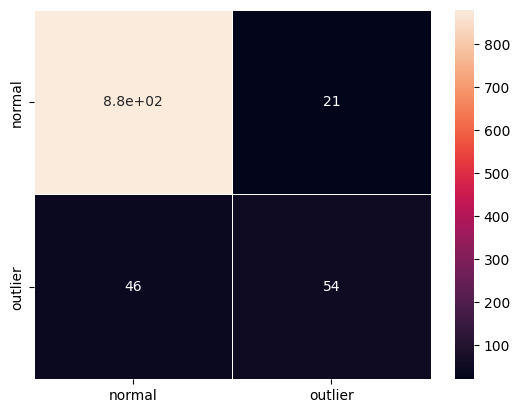

In [56]:
labels = ['normal', 'outlier']

y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))

cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

And then using a scatter plot and ROC curve:

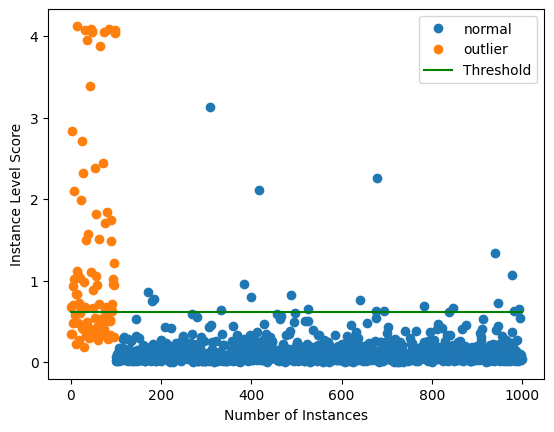

In [20]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

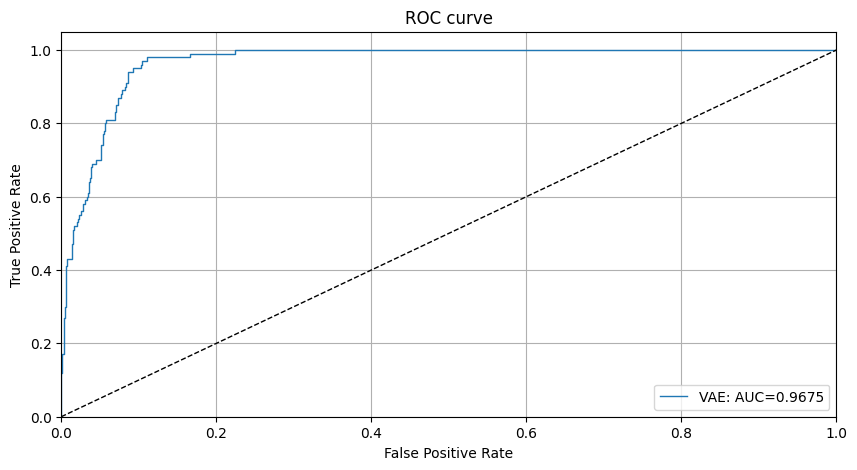

In [21]:
roc_data = {'VAE': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)

We can now save our outlier detector locally, create the `model-settings.json` file for the Outlier Detector and subsequently push the artefacts to our GCS Storage Bucket. 

In [58]:
save_detector(od, "outlier_detector")

In [59]:
%%writefile outlier_detector/model-settings.json
{
    "implementation": "mlserver_alibi_detect.AlibiDetectRuntime"
}

Overwriting outlier_detector/model-settings.json


In [60]:
!gsutil cp -r outlier_detector gs://kelly-seldon/retail-workshop/models/kelly/lr/outlier-detector

Copying file://outlier_detector/OutlierVAE.dill [Content-Type=application/octet-stream]...
Copying file://outlier_detector/model-settings.json [Content-Type=application/json]...
Copying file://outlier_detector/meta.dill [Content-Type=application/octet-stream]...
Copying file://outlier_detector/model/vae.ckpt.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [4 files][  7.6 KiB/  7.6 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://outlier_detector/model/decoder_net.h5 [Content-Type=application/x-hdf5]...
Copying file://outlier_detector/model/checkpoint [Content-Type=application/octet-stream]...
Copying file://outlier_detector/model/vae.ckpt.index [Content-Type=application/octet-stream]...
Copying file://o

We can then deploy this Outlier Detector alongside our model through the Seldon Deploy Advanced UI. 

Finally, we can test the Outlier Detector with the following inlier request:

```
{
    "parameters": {
        "content_type": "pd"
    },
    "inputs": [
        {   
            "name": "mean",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.43831067]
        },
        {   
            "name": "cat_0",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.23457404]
        },
        {   
            "name": "cat_1",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.17366155]
        },
        {   
            "name": "cat_2",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.26935668]
        },
        {   
            "name": "cat_3",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [0.13463672]
        },
        {   
            "name": "cat_4",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [-0.55234561]
        }
    ]
}
```

And then with a massive outlier:

```
{
    "parameters": {
        "content_type": "pd"
    },
    "inputs": [
        {   
            "name": "mean",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        },
        {   
            "name": "cat_0",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        },
        {   
            "name": "cat_1",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        },
        {   
            "name": "cat_2",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        },
        {   
            "name": "cat_3",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        },
        {   
            "name": "cat_4",
            "shape": [1,1],
            "datatype": "FP32",
            "data": [10]
        }
    ]
}
```